In [1]:
import numpy as np
import tensorflow as tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
filenames = ['./training_data/yelp_labelled.txt', './training_data/imdb_labelled.txt', './training_data/amazon_cells_labelled.txt']
with open('./training_data/training.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

In [3]:
filename = "./training_data/training.txt"
with open(filename, "r", encoding='utf-8') as infile, open('./training_data/positiveReviews.txt','w') as pf, open('./training_data/negativeReviews.txt','w') as nf:
    for line in infile:
        data = line.rsplit(None,1)
        class_label = int(data[-1])
        review = data[0]
        if class_label == 1:
#             print(review)
            pf.write(str(review)+"\n")
        else:
            nf.write(str(review)+"\n")
#             print(review)

In [4]:
# 6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors
wordsList = np.load('./training_data/wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('./training_data/wordVectors.npy')
print ('Loaded the word vectors!')

Loaded the word list!
Loaded the word vectors!


In [5]:
print(len(wordsList))
print(wordVectors.shape)

400000
(400000, 50)


In [6]:
positiveReviews = ['./training_data/positiveReviews.txt']
negativeReviews = ['./training_data/negativeReviews.txt']

wordCount = []
for pr in positiveReviews:
    with open(pr, "r", encoding='utf-8') as f:
        for line in f:
            counter = len(line.split())
#             print(counter)
            wordCount.append(counter)
print('Positive Reviews counted')

for nr in negativeReviews:
    with open(nr, "r", encoding='utf-8') as f:
        for line in f:
            counter = len(line.split())
            wordCount.append(counter)
print('Negative Reviews counted')

numReviews = len(wordCount)
print('Total number of reviews: ', numReviews)
print('Total number of words: ', sum(wordCount))
print('Average of words in reviews: ', sum(wordCount)/numReviews)


Positive Reviews counted
Negative Reviews counted
Total number of reviews:  3000
Total number of words:  35495
Average of words in reviews:  11.831666666666667


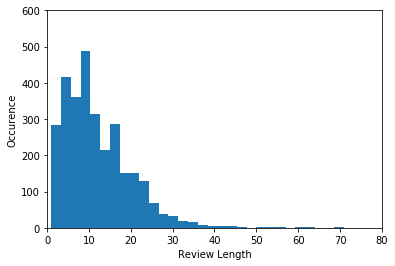

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(wordCount, 30)
plt.xlabel('Review Length')
plt.ylabel('Occurence')
plt.axis([0, 80, 0, 600])
plt.show()

In [8]:
maxReviewLength = 25

In [9]:
# with open(pr) as f:
#     sampleSentence = f.readlines()
#     print(sampleSentence[3])

In [10]:
# Removes unnecessary punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [11]:
firstSentence = np.zeros((maxReviewLength), dtype='int32')
with open(pr) as f:
    indexCounter = 0
    lines=f.readlines()
#     print(lines[125])
    cleanedLine = cleanSentences(lines[0])
    print(cleanedLine)
    split = cleanedLine.split()
    for word in split:
        if indexCounter < maxReviewLength:
            try:
                firstSentence[indexCounter] = wordsList.index(word)
            except ValueError:
                firstSentence[indexCounter] = 399999 #Vector for unknown words
        indexCounter = indexCounter + 1
firstSentence

wow loved this place


array([14397,  4146,    37,   241,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)

In [12]:
ids = np.zeros((numReviews, maxReviewLength), dtype='int32')
reviewCounter = 0

for pr in positiveReviews:
    with open(pr, "r") as f:
        lines = f.readlines()
        for line in lines:
            i = 0
            cleanedLine = cleanSentences(line)
#             print(cleanedLine)
            split = cleanedLine.split()
            for word in split:
#                 print(i)
                try:
                    ids[reviewCounter][i] = wordsList.index(word)
                except ValueError:
                    ids[reviewCounter][i] = 399999
                i += 1
                if i >= maxReviewLength:
                    break
            reviewCounter += 1
            
for nr in negativeReviews:
    with open(nr, "r") as f:
        lines = f.readlines()
        for line in lines:
            i = 0
            cleanedLine = cleanSentences(line)
            split = cleanedLine.split()
            for word in split:
#                 print(reviewCounter, i)
                try:
                    ids[reviewCounter][i] = wordsList.index(word)
                except ValueError:
                    ids[reviewCounter][i] = 399999
                i += 1
                if i >= maxReviewLength:
                    break
            reviewCounter += 1
            
np.save('idsMatrix', ids)

In [13]:
print(ids)
print(ids.shape)

[[ 14397   4146     37 ...      0      0      0]
 [  1821     21    105 ...      0      0      0]
 [201534   3692     13 ...      0      0      0]
 ...
 [  6779    260     36 ...      0      0      0]
 [201534     91    873 ...      0      0      0]
 [    81     86     36 ...      0      0      0]]
(3000, 25)


In [14]:
# Helper function for splitting Train/Test batch

from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxReviewLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,1350)
            labels.append([1,0])
        else:
            num = randint(1650,3000)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxReviewLength])
    for i in range(batchSize):
        num = randint(1350,1650)
        if (num <= 1500):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

In [15]:
batchSize = 20
lstmUnits = 16
numClasses = 2
iterations = 100001

In [16]:
import tensorflow as tf
tf.reset_default_graph()

with tf.name_scope('input_placeholders'):
    labels = tf.placeholder(tf.float32, [batchSize, numClasses], name="sentiment_labels")
    input_data = tf.placeholder(tf.int32, [batchSize, maxReviewLength], name="input_vector")

In [17]:
numDimensions = 300

with tf.name_scope('word_embedding_array'):
    data = tf.Variable(tf.zeros([batchSize, maxReviewLength, numDimensions]),dtype=tf.float32, name="3D_array")
    data = tf.nn.embedding_lookup(wordVectors,input_data, name="Integerizer")

In [18]:
with tf.name_scope('LSTM_Params'):
    lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
    lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
    value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

In [19]:
with tf.name_scope('LSTM_NN'):
    weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]), name="weight")
    bias = tf.Variable(tf.constant(0.1, shape=[numClasses]), name="bias")
    value = tf.transpose(value, [1, 0, 2], name="transposed_output")
    last = tf.gather(value, int(value.get_shape()[0]) - 1, name="last")
    prediction = (tf.matmul(last, weight) + bias)

In [20]:
with tf.name_scope('Prediction'):
    correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1), name="correct_prediction")
    accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32), name="accuracy")

In [21]:
with tf.name_scope('Optimizers'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels), name="Mean_Loss")
    optimizer = tf.train.AdamOptimizer(name="adam_optimizer").minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [22]:
import datetime

with tf.Session() as sess:
    tf.summary.scalar('Loss', loss)
    tf.summary.scalar('Accuracy', accuracy)
    merged = tf.summary.merge_all()
    logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)

In [23]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

for i in range(iterations):
    # Next Batch of reviews 
    nextBatch, nextBatchLabels = getTrainBatch()
    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
   
   #Write summary to Tensorboard
    if (i % 50 == 0):
        summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
        writer.add_summary(summary, i)

   #Save the network every 10,000 training iterations
    if (i % 10000 == 0 and i != 0):
        save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
        print("saved to %s" % save_path)
        
sess.graph.as_graph_def()
file_writer = tf.summary.FileWriter("./graphLSTM", sess.graph)
writer.close()

saved to models/pretrained_lstm.ckpt-1000


In [24]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('models'))

INFO:tensorflow:Restoring parameters from models/pretrained_lstm.ckpt-1000


/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [25]:
iterations = 10
kFoldAvgAcc = []
kFoldAvgLoss = []
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch()
    kFoldAvgAcc.append((sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)
    kFoldAvgLoss.append((sess.run(loss, {input_data: nextBatch, labels: nextBatchLabels})) * 100)
    print("Accuracy for fold", i+1, ":" , (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

print(iterations, "Fold Cross Validation Average Accuracy: ", sum(kFoldAvgAcc) / float(len(kFoldAvgAcc)))
# don't know why the loss is so low. 
print(iterations, "Fold Cross Validation Average Loss: ", sum(kFoldAvgLoss) / float(len(kFoldAvgLoss)))

Accuracy for fold 1 : 85.00000238418579
Accuracy for fold 2 : 85.00000238418579
Accuracy for fold 3 : 69.9999988079071
Accuracy for fold 4 : 80.0000011920929
Accuracy for fold 5 : 85.00000238418579
Accuracy for fold 6 : 69.9999988079071
Accuracy for fold 7 : 85.00000238418579
Accuracy for fold 8 : 85.00000238418579
Accuracy for fold 9 : 69.9999988079071
Accuracy for fold 10 : 64.99999761581421
10 Fold Cross Validation Average Accuracy:  78.50000023841858
10 Fold Cross Validation Average Loss:  44.033766090869904
